In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import glob
import numpy as np
import pandas as pd 
import nibabel as nib
from nilearn.input_data import NiftiMasker
from matplotlib import pyplot as plt
import seaborn as sns

from himalaya.scoring import correlation_score
from scipy import sparse
from neuromaps.transforms import fsaverage_to_fsaverage

sys.path.append('../utils/') 

from config import *
import dataset_utils as utils
from tommy_utils import statistics, plotting, encoding

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
dataset = 'huth-moth'
model_name = 'gpt2-xl'
task = 'wheretheressmoke' # only evaluate for one test task for now

results_dir = os.path.join(BASE_DIR, 'derivatives/results/', dataset) #, p.sub, p.model_name)
plots_dir = os.path.join(BASE_DIR, 'derivatives/plots/encoding_preds/', dataset, 'group')

utils.attempt_makedirs(plots_dir)

if dataset == 'deniz-readinglistening':
    data_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/dark-matter-preproc/')
else:
    data_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/dark-matter-preproc-smooth/')
    masks_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/masks/group/')
    mask_fn = os.path.join(masks_dir, 'group-MNI152NLin6Asym_res-all_desc-brain_gm-mask-intersection.nii.gz')
    masker = NiftiMasker(mask_fn).fit()

### Set subjects for dataset

In [3]:
# get subjects excluding their html files
sub_dirs = sorted(glob.glob(os.path.join(data_dir, 'sub*[!html]')))
sub_list = [os.path.basename(d) for d in sub_dirs]

### Set n_subs significance threshold

In [4]:
N_SUBS_SIGNIF_THRESHOLD = 3

## Calculate # of subjects significant at each voxel

In [5]:
# go through each subject and load their permutations
sub_significance_counts = []
sub_prediction_accuracy = []
sub_pvals = []
session = '' #'reading' #''

for sub in sub_list:
    sub_data_dir = os.path.join(data_dir, sub)
    sub_results_dir = os.path.join(results_dir, sub, model_name)
    sub_permutations_fn = glob.glob(os.path.join(sub_results_dir, f'*{task}*permutations*.npy'))

    if dataset == 'deniz-readinglistening':
        
        # sub_mapper_fn = glob.glob(os.path.join(data_dir, sub, 'mappers', '*fsaverage*'))
        
        # assert (len(sub_mapper_fn) == 1)

        # mapper = sparse.load_npz(sub_mapper_fn[0])
        if session:
            sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{session}*{task}*hyperaligned.npy')))
            sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{session}*{task}*prediction*ground-truth*.npy')))
            sub_permutations_fn = glob.glob(os.path.join(sub_results_dir, f'*{session}*{task}*permutations*.npy'))
        else:
            sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{task}*hyperaligned.npy')))
            sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{task}*prediction*ground-truth*.npy')))    
    else:
        sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{task}*hyperaligned.npy')))
        sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{task}*prediction*ground-truth*.npy')))

    # load ground-truth predictions --> predictions are the same regardless of run since weights dont change
    assert (len(sub_permutations_fn) == 1 and (len(sub_data_fn) == 5 or len(sub_data_fn) == 2))

    # load results, average and correlate with ground truth
    ds_test = np.mean([np.load(fn) for fn in sub_data_fn], axis=0)
    Y_pred = np.mean([np.load(fn) for fn in sub_results_fn], axis=0)
    
    # load the data
    distribution = np.load(sub_permutations_fn[0])
    results = correlation_score(ds_test, Y_pred)
    
    # compare the results to the distribution and then find what is significant
    zvals, pvals = statistics.p_from_null(results[np.newaxis], distribution, mult_comp_method='fdr_bh', axis=0)    
    thresholded = statistics.pvalue_threshold(results, pvals)

    significant_voxels = ~np.isnan(thresholded)

    # if dataset == 'deniz-readinglistening':
    #     significant_voxels = significant_voxels @ mapper.T
    #     prediction_accuracy = results @ mapper.T
    # else:
    #     prediction_accuracy = results
    
    sub_significance_counts.append(significant_voxels)
    sub_prediction_accuracy.append(results)
    sub_pvals.append(pvals)

# stack together
sub_significance_counts = np.stack(sub_significance_counts)

# now count number of participants 
significance_counts = np.sum(sub_significance_counts, axis=0).astype(float)
significance_counts[significance_counts < 1] = np.nan

KeyboardInterrupt: 

### Plot the signficance counts

In [271]:
# set title and filename for writing
if session:
    ses = f'_ses-{session}_'
else:
    ses = '_'
    
out_fn = os.path.join(plots_dir, f'group{ses}task-{task}_nsubs-significance.{EXT}')
title = '' #f'{dataset} - All {session} stories, n_subs significance'#f'group - n_subs significance'

significance_cmap = plt.cm.get_cmap('magma', len(sub_list))    # 11 discrete colorsp
max_val = np.nanmax(significance_counts)

if dataset == 'deniz-readinglistening':
    surfs, data = plotting.numpy_to_surface(significance_counts, target_density='41k', method='nearest')
else:
    ds_signif = masker.inverse_transform(significance_counts)
    surfs, data = plotting.vol_to_surf(ds_signif, surf_type='fsaverage', map_type='inflated', method='nearest')

layer = plotting.make_layers_dict(data=data, cmap=significance_cmap, label=f'N_Subjects Significant', alpha=1, color_range=(1, len(sub_list)))

/scratch/ipykernel_23534/4137601899.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  significance_cmap = plt.cm.get_cmap('magma', len(sub_list))    # 11 discrete colorsp


In [272]:
if PLOT_SEPARATE_VIEWS:
        for view in VIEWS:
            _ = plotting.plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
                add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'),
                title=title)
else:
    _ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
        add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

Here
Here


## Plot average ground-truth prediction accuracy

In [28]:
def ztransform_mean(dss):
    dss = np.stack(dss)
    return np.tanh(np.mean([np.arctanh(ds) for ds in dss], axis=0))

### Now plot for both thresholded and unthresholded

In [273]:
# accuracy contains both stat test thresholded and unthresholded accuracy
plot_types = ['thresholded', 'unthresholded']

sub_prediction_accuracy = np.stack(sub_prediction_accuracy)
avg_accuracy = ztransform_mean(sub_prediction_accuracy)

for name in plot_types:
    
    if name == 'thresholded':
        signif_threshold = np.logical_or(np.isnan(significance_counts), significance_counts < N_SUBS_SIGNIF_THRESHOLD)
        accuracy = avg_accuracy.copy()
        accuracy[signif_threshold] = np.nan
    else:
        accuracy = avg_accuracy.copy()
    
    # set title and filename for writing
    if session:
        ses = f'_ses-{session}_'
    else:
        ses = '_'
        
    out_fn = os.path.join(plots_dir, f'group{ses}task-{task}_run-avg-{name}.{EXT}')
    title = '' #f'{dataset} - All {session} stories, n_subs significance'#f'group - n_subs significance'
    max_val = np.nanmax(abs(accuracy))
    
    if dataset == 'deniz-readinglistening':
        surfs, data = plotting.numpy_to_surface(accuracy, target_density='41k')
    else:
        ds_avg = masker.inverse_transform(accuracy)
        surfs, data = plotting.vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
    
    layer = plotting.make_layers_dict(data=data, cmap='RdBu_r', label=f'Prediction (r)', alpha=1, color_range=(-max_val, max_val))
    
    if PLOT_SEPARATE_VIEWS:
            for view in VIEWS:
                _ = plotting.plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
                    add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'),
                    title=title)
    else:
        _ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
            add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

Here
Here
Here
Here


## Conduct contrasts of MSE

### Determine critical word trs

In [251]:
# load gentle trasncript
gentle_dir = os.path.join(DATASETS_DIR, dataset, 'stimuli', 'gentle', task)
transcript_fn = os.path.join(gentle_dir, 'align.json')

df_transcript = encoding.load_gentle_transcript(
    transcript_fn=transcript_fn, 
    start_offset=None #stim_times[0] if stim_times else None
)

## MAKE ADJUSTMENTS TO MODEL FEATURES FROM BEHAVIOR ########
behavior_results_fn = os.path.join(BASE_DIR, f'derivatives/results/behavioral/task-{task}_compiled-behavior.csv')
behavior_results = pd.read_csv(behavior_results_fn)

crit_idxs = np.unique(behavior_results['word_index'])

# get critical word trs
critical_word_trs = df_transcript.loc[crit_idxs, ['start', 'end']] // 2
critical_word_trs = critical_word_trs['end'].astype(int).to_numpy()
print (f'Total trs: {len(critical_word_trs)}')

# reduce to unique critical words
critical_word_trs = np.unique(critical_word_trs)
print (f'Unique trs: {len(critical_word_trs)}')

Total trs: 237
Unique trs: 195


### Calculate contrast of residuals for each subject

In [252]:
def calculate_error(Y_true, Y_pred, crit_trs):
    absolute_error = abs(Y_true - Y_pred)[crit_trs, :]

    mse = (Y_true - Y_pred)**2
    mse = mse[crit_trs, :]
    
    return absolute_error, mse

def get_residuals_df(sub, residuals, feature_names, significant):
    
    all_contrasts = []
    
    runs = [f'run-{i+1}' for i in np.arange(5)]
    runs += ['run-avg']
    
    for i, name in enumerate(feature_names):
         # first average across time
            
        voxelwise_residuals = residuals[i].mean(1)
#         voxelwise_diff = (abs(residuals[comp_idxs[0]]) - abs(residuals[comp_idxs[1]])).mean(1)
        
        df_voxels = pd.DataFrame(voxelwise_residuals.T, columns=runs)
        
        df_voxels = df_voxels.reset_index().rename(columns={'index': 'voxel'})
        df_voxels['sub'] = sub
        df_voxels['feature_name'] = name
        df_voxels['significant'] = significant
        df_voxels = pd.melt(df_voxels, id_vars=['voxel', 'sub', 'feature_name', 'significant'], var_name='run', value_name='resid')
        
        all_contrasts.append(df_voxels)
    
    return pd.concat(all_contrasts)

def conduct_feature_contrasts(ds_dict, feature_contrasts):

    # all_contrasts = []
    
    all_contrasts = {}
    
    for contrast in feature_contrasts:
        ds_a, ds_b = [ds_dict[c] for c in contrast]

        contrast_key = ' - '.join(contrast)
        # df_a, df_b = [df[df['feature_name'] == c] for c in contrast]
        
        # copy a dataframe and we'll insert to perform contrast
        # df_contrast = df_a.copy()
        # df_contrast['resid'] = df_a['resid'] - df_b['resid']
        # df_contrast['feature_name'] = ' - '.join(contrast)

        all_contrasts[contrast_key] = ds_a - ds_b
        print (f'Finished contrast {contrast}')
    
    # df_contrast = pd.concat(all_contrasts)
    # df_contrast.rename(columns={'feature_name':'contrast'}, inplace=True)

    return all_contrasts

In [298]:
feature_contrasts = [
    ['model-predicted', 'human-audio'],
    ['model-predicted', 'human-text'],
    # ['model-predicted', 'ground-truth'],
    # ['human-audio', 'ground-truth'],
    # ['human-text', 'ground-truth'],
    ['human-audio', 'human-text'] 
]

behavioral_feature_types = ['model-predicted', 'human-audio', 'human-text'] #'ground-truth', 

# initialize dictionary of contrasts
all_contrasts = {' - '.join(contrast): [] for contrast in feature_contrasts}

all_sub_residuals = {dtype: [] for dtype in behavioral_feature_types}

for sub, pvals in zip(sub_list, sub_pvals):
    
    sub_results_dir = os.path.join(results_dir, sub, model_name)
    sub_data_dir = os.path.join(data_dir, sub)
    
    ds_sub_residuals = {} 

    for behavioral_type in behavioral_feature_types:

        if dataset == 'deniz-readinglistening':
            # sub_mapper_fn = glob.glob(os.path.join(data_dir, sub, 'mappers', '*fsaverage*'))
            
            # assert (len(sub_mapper_fn) == 1)
    
            # mapper = sparse.load_npz(sub_mapper_fn[0])
    
            if session:
                sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{session}*{task}*hyperaligned.npy')))
                sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{session}*{task}*prediction*{behavioral_type}*.npy')))
            else:
                sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{task}*hyperaligned.npy')))
                sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{task}*prediction*{behavioral_type}*.npy')))    
        else:
            
            sub_data_fn = sorted(glob.glob(os.path.join(sub_data_dir, f'*{task}*hyperaligned.npy')))
            sub_results_fn = sorted(glob.glob(os.path.join(sub_results_dir, f'*{task}*prediction*{behavioral_type}*.npy')))
    
         # load ground-truth predictions --> predictions are the same regardless of run since weights dont change
        assert ((len(sub_data_fn) == 5 or len(sub_data_fn) == 2))
    
        # load results, average and correlate with ground truth
        Y_true = np.mean([np.load(fn) for fn in sub_data_fn], axis=0)
        Y_pred = np.mean([np.load(fn) for fn in sub_results_fn], axis=0)
    
        absolute_error, mse = calculate_error(Y_true, Y_pred, critical_word_trs)
        ds_sub_residuals[behavioral_type] = mse

        print (f'Finished {sub} {behavioral_type}')

    # df_sub_residuals = pd.concat(df_sub_residuals)
    sub_contrast_dict = conduct_feature_contrasts(ds_sub_residuals, feature_contrasts)
    
    for k, v in all_contrasts.items():
        # map to fsaverage space
        # if dataset == 'deniz-readinglistening':
        #     sub_contrast_dict[k] = sub_contrast_dict[k] @ mapper.T
        v.append(sub_contrast_dict[k])

    for k, v in all_sub_residuals.items():
        # map to fsaverage space
        # if dataset == 'deniz-readinglistening':
        #     ds_sub_residuals[k] = ds_sub_residuals[k] @ mapper.T
        v.append(ds_sub_residuals[k])

all_contrasts = {k: np.stack(v).squeeze() for k, v in all_contrasts.items()}
all_sub_residuals = {k: np.stack(v).squeeze() for k, v in all_sub_residuals.items()}

Finished sub-UTS01 model-predicted
Finished sub-UTS01 human-audio
Finished sub-UTS01 human-text
Finished contrast ['model-predicted', 'human-audio']
Finished contrast ['model-predicted', 'human-text']
Finished contrast ['human-audio', 'human-text']
Finished sub-UTS02 model-predicted
Finished sub-UTS02 human-audio
Finished sub-UTS02 human-text
Finished contrast ['model-predicted', 'human-audio']
Finished contrast ['model-predicted', 'human-text']
Finished contrast ['human-audio', 'human-text']
Finished sub-UTS03 model-predicted
Finished sub-UTS03 human-audio
Finished sub-UTS03 human-text
Finished contrast ['model-predicted', 'human-audio']
Finished contrast ['model-predicted', 'human-text']
Finished contrast ['human-audio', 'human-text']
Finished sub-UTS04 model-predicted
Finished sub-UTS04 human-audio
Finished sub-UTS04 human-text
Finished contrast ['model-predicted', 'human-audio']
Finished contrast ['model-predicted', 'human-text']
Finished contrast ['human-audio', 'human-text']
Fini

### Plot degree human (regardless of modality) is better than model

In [300]:
human_v_model_maxes = [
    ('deniz-listening', 0.029139802),
    ('deniz-reading', 0.027565988),
    ('huth-moth', 0.027026424)
]

In [312]:
0.027026424 / 2

0.013513212

In [299]:
human_v_model = (all_contrasts['model-predicted - human-audio'] + all_contrasts['model-predicted - human-text']) / 2

for name in plot_types:
    # average across subjects then trs
    avg_contrast = np.nanmean(np.nanmean(human_v_model, axis=0), axis=0) #.mean(1).mean(0)
    
    if name == 'thresholded':
        signif_threshold = np.logical_or(np.isnan(significance_counts), significance_counts < N_SUBS_SIGNIF_THRESHOLD)
        avg_contrast[signif_threshold] = np.nan

    print (np.nanmax(abs(avg_contrast)))
    sys.exit(0)
    
    # set title and filename for writing
    if session:
        ses = f'_ses-{session}_'
    else:
        ses = '_'
        
    out_fn = os.path.join(plots_dir, f"group{ses}task-{task}_model-predicted_human-contrast_run-avg-contrast-{name}.{EXT}")
    
    title = '' #f'{dataset} - {ses} MSE contrast, {contrast}'#f'group - n_subs significance'
    max_val = np.nanmax(abs(avg_contrast))
    
    if dataset == 'deniz-readinglistening':
        surfs, data = plotting.numpy_to_surface(avg_contrast, target_density='41k')
    else:
        ds_avg = masker.inverse_transform(avg_contrast)
        surfs, data = plotting.vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
    
    layer = plotting.make_layers_dict(data=data, cmap='RdBu_r', label='model-predicted - human-predicted', alpha=1, color_range=(-max_val, max_val))
    
    if PLOT_SEPARATE_VIEWS:
            for view in VIEWS:
                _ = plotting.plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
                    add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'),
                    title=title)
    else:
        _ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
            add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

0.027026424


SystemExit: 0

### Plot as quadrants

In [276]:
signif_threshold = np.logical_or(np.isnan(significance_counts), significance_counts < N_SUBS_SIGNIF_THRESHOLD)

human_v_model = all_contrasts['model-predicted - human-audio'] + all_contrasts['model-predicted - human-text']
avg_human_model_contrast = np.nanmean(np.nanmean(human_v_model, axis=0), axis=0) #.mean(1).mean(0)

spoken_v_written = all_contrasts['human-audio - human-text']
spoken_v_written = -1 * spoken_v_written

avg_spoken_written_contrast = np.nanmean(np.nanmean(spoken_v_written, axis=0), axis=0) #.mean(1).mean(0)
avg_spoken_written_contrast[signif_threshold] = np.nan


xmax = np.nanmax(np.abs(avg_human_model_contrast))
ymax = np.nanmax(np.abs(avg_spoken_written_contrast))

In [232]:
def create_blended_colors(x, y, cmap1, cmap2):
    """Blend two colormaps in 2D."""

    # norm values 
    x_norm = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
    y_norm = (y - np.nanmin(y)) / (np.nanmax(y) - np.nanmin(y))

    colors = []
    for x, y in zip(x_norm, y_norm):
        color = (np.array(cmap1(x)) + np.array(cmap2(y))) / 2
        colors.append(color)
    # # Generate linearly spaced values for x and y
    # x_values = np.linspace(0, 1, 256)
    # y_values = np.linspace(0, 1, 256)

    # x_steps = list(range(256))
    # y_steps = list(range(256))

    # arr = np.ones((256, 256, 3))
    
    # for x, y in product(x_steps, y_steps):
    #     arr[x, y] = np.stack(cmap1(x_values[x])) / 
        
    #     np.mean(
    #          + 
    #         np.stack(cmap1(x_values[x])) # cmap2(y_values[y]))

    return colors



In [204]:
spoken_written_colormap = create_spoken_written_cmap()
human_model_cmap = cmap.get_cmap('RdBu_r')

In [233]:
colors = create_blended_colors(avg_human_model_contrast, avg_spoken_written_contrast, human_model_cmap, spoken_written_colormap)

In [235]:
pd.__version__

'1.2.2'

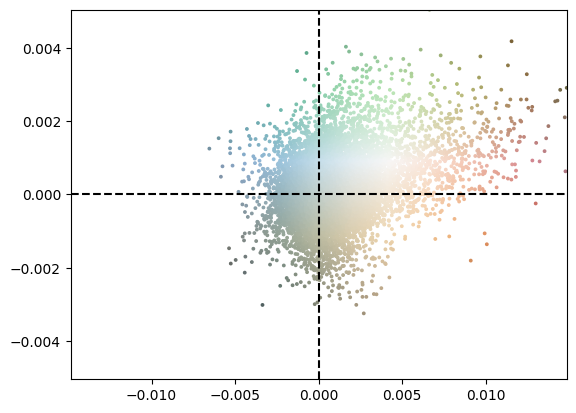

In [234]:
plt.scatter(avg_human_model_contrast, avg_spoken_written_contrast, s=3, c=colors)
plt.xlim([-xmax, xmax])
plt.ylim([-ymax, ymax])

plt.vlines(x=0, ymin=-ymax, ymax=ymax, linestyles='dashed', color='k')
plt.hlines(y=0, xmin=-xmax, xmax=xmax, linestyles='dashed', color='k')

### Plot average of contrast across subjects

In [18]:
import matplotlib.colors as clr

def create_spoken_written_cmap():
    spoken_written_cmap = clr.LinearSegmentedColormap.from_list('spoken-written', ['#005208', '#72D16B', '#F7F6F6', '#E4B266', '#623800'], N=256)
    spoken_written_cmap = spoken_written_cmap.reversed()
    spoken_written_cmap
    return spoken_written_cmap

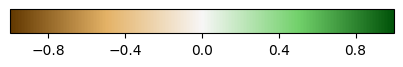

In [297]:
plotting.plot_colorbar(-1, 1, nticks=5, cmap=spoken_written_cmap, out_fn='spoken-written-cbar.pdf')

In [ ]:
spoken_written_maxes = [
    ('deniz-listening', 0.017292226),
    ('deniz-reading', 0.015913997),
    ('huth-moth', 0.009970156)
]

In [301]:
plot_types = ['thresholded', 'unthresholded']

spoken_written_colormap = create_spoken_written_cmap()

for contrast, ds_contrast in all_contrasts.items():

    if contrast != 'human-audio - human-text':
        continue
    else:
        ds_contrast = -1 * ds_contrast
    
    for name in plot_types:
        # average across subjecst and then trs
        avg_contrast = np.nanmean(np.nanmean(ds_contrast, axis=0), axis=0) #.mean(1).mean(0)
        
        if name == 'thresholded':
            signif_threshold = np.logical_or(np.isnan(significance_counts), significance_counts < N_SUBS_SIGNIF_THRESHOLD)
            avg_contrast[signif_threshold] = np.nan

        print (np.nanmax(abs(avg_contrast)))
        sys.exit(0)
        # set title and filename for writing
        if session:
            ses = f'_ses-{session}_'
        else:
            ses = '_'
            
        out_fn = os.path.join(plots_dir, f"group{ses}task-{task}_{contrast.replace(' - ', '_')}_run-avg-contrast-{name}.{EXT}")

        title = '' #f'{dataset} - {ses} MSE contrast, {contrast}'#f'group - n_subs significance'
        max_val = np.nanmax(abs(avg_contrast))

        
        print (contrast)
        print (max_val)
        
        if dataset == 'deniz-readinglistening':
            surfs, data = plotting.numpy_to_surface(avg_contrast, target_density='41k')
        else:
            ds_avg = masker.inverse_transform(avg_contrast)
            surfs, data = plotting.vol_to_surf(ds_avg, surf_type='fsaverage', map_type='inflated')
        
        layer = plotting.make_layers_dict(data=data, 
                                          cmap=spoken_written_colormap if contrast == 'human-audio - human-text' else 'RdBu_r', 
                                          label=contrast, alpha=1, color_range=(-max_val, max_val))
        
        if PLOT_SEPARATE_VIEWS:
                for view in VIEWS:
                    _ = plotting.plot_surf_data(surfs, [layer], views=[view], colorbar=COLORBAR, surf_type=SURF_TYPE, 
                        add_depth=ADD_DEPTH, out_fn=out_fn.replace(f'.{EXT}', f'-{view}.{EXT}'),
                        title=title)
        else:
            _ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=COLORBAR, surf_type=SURF_TYPE, 
                add_depth=ADD_DEPTH, out_fn=out_fn, title=title)

0.009970156


SystemExit: 0